In [ ]:
#hide 

%load_ext autoreload
%autoreload 2

In [ ]:
#default_exp train

# Train
> Training and evaluation of the model using FastAI utilities

In [ ]:
#exporti

from transformers import DistilBertTokenizer
from fastai.data.core import DataLoaders
from fastai.vision.all import *
from DSAI_proj.dataset import *
from DSAI_proj.model import *
from fastai.vision import *
from torch import nn
from pandas import DataFrame
import torch

First, let's create our loss function. This will tell our model how wrong it is by calculating how far the predictions are from the output. Here, we will use cross entropy loss as our criterion. We can do this by viewing each token as a separate class, and hence provide a one-for-one comparison of tokens at each position.

In [ ]:
#export

class TagLineLoss(nn.Module):
    
    def __init__(self):
        super(TagLineLoss, self).__init__()
        self.criterion = torch.nn.CrossEntropyLoss()
    
    def forward(self, output, target):
        return self.criterion(input=output, target=target)

We also define a splitter which will group the parameters of the different models to allow for unfreezing of the layers subsequently. 

In [ ]:
#export

def splitter_func(model: nn.Module):
    return [params(model.cnn_encoder),
            params(model.text_encoder),
            params(model.meta_encoder),
            params(model.decoder)]

In [ ]:
#hide

# dataset creation
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
poster_img_dir = "poster_img/"
backdrop_img_dir = "backdrop_img/"
input_max_length, labels_max_length = 80, 10
height = width = 128
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
bs = 32

tfms = Compose([Tokenize(tokenizer=tokenizer, input_max_length=input_max_length, labels_max_length=labels_max_length),
                         RandomResizeCrop(width=width, height=height, method=Image.BILINEAR),
                         ToTensor(),
                         NormalizeStandardize(mean=mean, std=std)])

train_ds = MovieDataset(poster_img_dir=poster_img_dir,
                        backdrop_img_dir=backdrop_img_dir,
                        ds_type="train",
                        transforms=tfms)

valid_ds = MovieDataset(poster_img_dir=poster_img_dir,
                        backdrop_img_dir=backdrop_img_dir,
                        ds_type="valid",
                        transforms=tfms)

dls = DataLoaders.from_dsets(train_ds, valid_ds, batch_size=bs)
sample = dls.one_batch()
model = TaglinePredictorModel(vocab_size=30522, meta_features=sample[0][3].shape[-1])

train dataset created!
valid dataset created!
Model is created!


Finally, we can begin the training. To do this, we leverage the FastAI library as a training vehicle as it provides many advanced training techniques at our fingertips with simple APIs. 

In [ ]:
learn = Learner(dls, model, loss_func=TagLineLoss(), opt_func=Adam, splitter=splitter_func, cbs=CudaCallback, wd=1e-3).to_fp16()

We run a function called lr_find first which plots different learning rates against loss. We use this to determine an optimal learning rate for our task. We pick the learning rate corresponding to the middle point of the steepest part of the downward sloping curve, which in this case is about 1e-2.

SuggestedLRs(lr_min=0.10964782238006592, lr_steep=0.9120108485221863)

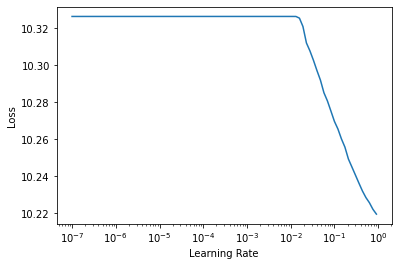

In [ ]:
learn.lr_find()

We then run a fit on the model for 2 epochs first to verify it's progress. 

In [ ]:
learn.fit_one_cycle(3, 1e-1)

epoch,train_loss,valid_loss,time
0,10.092417,10.073622,00:40
1,10.074081,10.073622,00:41
2,10.073076,10.073622,00:40


This is followed by a unfreezing of all layers and running of lr_find again to find the optimal lr range for this next phase of training. We notice that the graph now is relatively flat before suddenly spiking upwards. We will pick a learning rate way before the training diverges, in this case about 1e-5. 

We use something called differential learning rates to train different parts of the model at different learning rates. This is done at the next stage using the slice. The upper bound will be set at a factor of 10 less than the initial learning rate as good practice, so we will use 1e-3 in this case. This time, we train for 3 epochs instead as well.

SuggestedLRs(lr_min=0.00010000000474974513, lr_steep=4.365158383734524e-05)

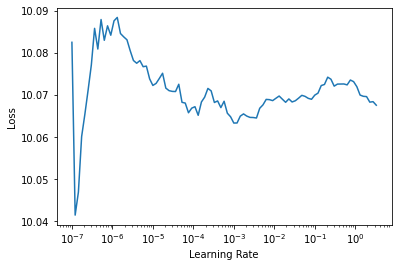

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,time
0,10.068838,10.073622,00:49
1,10.070781,10.073622,00:50
2,10.069448,10.073622,00:50
3,10.069201,10.073622,00:49
4,10.070787,10.073622,00:50


As we can see, even with extreme measures taken to avoid overfitting such as unfreezing batch/layer norm during fine-tuning, reducing batch size, adding weight decay, and cranking up the learning rate, the model still overfits at practically the first epoch. This probably means that the model architecture itself can be further improved, as well as the augmentation techniques. We shall explore these further in the next section on analysis. 

For now, we shall save the model to experiment on the test set.

In [ ]:
model = learn.model
save_path = 'saved_model.pt'
torch.save(model.state_dict(), save_path)

We shall also write the necessary functions for loading the saved model and generating the predictions.

In [ ]:
#exporti

def load_model(model_path: str, **kwargs):
    model = TaglinePredictorModel(**kwargs)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to("cpu")
    return model

In [ ]:
#export

def predict_one_batch(tokenizer,
                      dls,
                      mode: str,
                      model_path: str) -> DataFrame:

    if mode != "train":
        x, y = dls.valid.one_batch()
    else:
        x, y = dls.train.one_batch()
    model = load_model(model_path=model_path, vocab_size=30522, meta_features=x[3].shape[-1])
    x = model(x)
    preds = torch.argmax(x, dim=1)
    results = {"preds" : [tokenizer.decode(p) for p in preds], "labels" : [tokenizer.decode(t) for t in y]}
    return pd.DataFrame.from_dict(results)

In [ ]:
save_path = 'saved_model.pt'
results_df = predict_one_batch(tokenizer=tokenizer, dls=dls, mode="train", model_path=save_path)
results_df.head()

Model is created!


,preds,labels
0,[CLS] the's... [PAD] [PAD] [SEP],[CLS] rule school save world [SEP] [PAD] [PAD] [PAD] [PAD]
1,[CLS] the is s... [PAD] [PAD] [SEP],[CLS] every generation legend every journey first step every [SEP]
2,[CLS] the's. the.. [PAD] [SEP],[CLS] bad cops good cops's bullitt [SEP]
3,[CLS] the's.... [PAD] [SEP],[CLS] story won't go away [SEP] [PAD]
4,[CLS] the the s.... [PAD] [SEP],[CLS] one pillow bed... one desire [SEP]


In [ ]:
for k, v in tokenizer.vocab.items():
    print(k, v)

[PAD] 0
[unused0] 1
[unused1] 2
[unused2] 3
[unused3] 4
[unused4] 5
[unused5] 6
[unused6] 7
[unused7] 8
[unused8] 9
[unused9] 10
[unused10] 11
[unused11] 12
[unused12] 13
[unused13] 14
[unused14] 15
[unused15] 16
[unused16] 17
[unused17] 18
[unused18] 19
[unused19] 20
[unused20] 21
[unused21] 22
[unused22] 23
[unused23] 24
[unused24] 25
[unused25] 26
[unused26] 27
[unused27] 28
[unused28] 29
[unused29] 30
[unused30] 31
[unused31] 32
[unused32] 33
[unused33] 34
[unused34] 35
[unused35] 36
[unused36] 37
[unused37] 38
[unused38] 39
[unused39] 40
[unused40] 41
[unused41] 42
[unused42] 43
[unused43] 44
[unused44] 45
[unused45] 46
[unused46] 47
[unused47] 48
[unused48] 49
[unused49] 50
[unused50] 51
[unused51] 52
[unused52] 53
[unused53] 54
[unused54] 55
[unused55] 56
[unused56] 57
[unused57] 58
[unused58] 59
[unused59] 60
[unused60] 61
[unused61] 62
[unused62] 63
[unused63] 64
[unused64] 65
[unused65] 66
[unused66] 67
[unused67] 68
[unused68] 69
[unused69] 70
[unused70] 71
[unused71] 72
[un

4 1018
5 1019
6 1020
7 1021
8 1022
9 1023
: 1024
; 1025
< 1026
= 1027
> 1028
? 1029
@ 1030
[ 1031
\ 1032
] 1033
^ 1034
_ 1035
` 1036
a 1037
b 1038
c 1039
d 1040
e 1041
f 1042
g 1043
h 1044
i 1045
j 1046
k 1047
l 1048
m 1049
n 1050
o 1051
p 1052
q 1053
r 1054
s 1055
t 1056
u 1057
v 1058
w 1059
x 1060
y 1061
z 1062
{ 1063
| 1064
} 1065
~ 1066
¡ 1067
¢ 1068
£ 1069
¤ 1070
¥ 1071
¦ 1072
§ 1073
¨ 1074
© 1075
ª 1076
« 1077
¬ 1078
® 1079
° 1080
± 1081
² 1082
³ 1083
´ 1084
µ 1085
¶ 1086
· 1087
¹ 1088
º 1089
» 1090
¼ 1091
½ 1092
¾ 1093
¿ 1094
× 1095
ß 1096
æ 1097
ð 1098
÷ 1099
ø 1100
þ 1101
đ 1102
ħ 1103
ı 1104
ł 1105
ŋ 1106
œ 1107
ƒ 1108
ɐ 1109
ɑ 1110
ɒ 1111
ɔ 1112
ɕ 1113
ə 1114
ɛ 1115
ɡ 1116
ɣ 1117
ɨ 1118
ɪ 1119
ɫ 1120
ɬ 1121
ɯ 1122
ɲ 1123
ɴ 1124
ɹ 1125
ɾ 1126
ʀ 1127
ʁ 1128
ʂ 1129
ʃ 1130
ʉ 1131
ʊ 1132
ʋ 1133
ʌ 1134
ʎ 1135
ʐ 1136
ʑ 1137
ʒ 1138
ʔ 1139
ʰ 1140
ʲ 1141
ʳ 1142
ʷ 1143
ʸ 1144
ʻ 1145
ʼ 1146
ʾ 1147
ʿ 1148
ˈ 1149
ː 1150
ˡ 1151
ˢ 1152
ˣ 1153
ˤ 1154
α 1155
β 1156
γ 1157
δ 1158
ε 1159
ζ 1160

far 2521
co 2522
association 2523
hard 2524
already 2525
2002 2526
##ra 2527
championship 2528
human 2529
western 2530
100 2531
##na 2532
department 2533
hall 2534
role 2535
various 2536
production 2537
21 2538
19 2539
heart 2540
2001 2541
living 2542
fire 2543
version 2544
##ers 2545
##f 2546
television 2547
royal 2548
##4 2549
produced 2550
working 2551
act 2552
case 2553
society 2554
region 2555
present 2556
radio 2557
period 2558
looking 2559
least 2560
total 2561
keep 2562
england 2563
wife 2564
program 2565
per 2566
brother 2567
mind 2568
special 2569
22 2570
##le 2571
am 2572
works 2573
soon 2574
##6 2575
political 2576
george 2577
services 2578
taken 2579
created 2580
##7 2581
further 2582
able 2583
reached 2584
david 2585
union 2586
joined 2587
upon 2588
done 2589
important 2590
social 2591
information 2592
either 2593
##ic 2594
##x 2595
appeared 2596
position 2597
ground 2598
lead 2599
rock 2600
dark 2601
election 2602
23 2603
board 2604
france 2605
hair 2606
course 2607
arms

##ti 3775
estate 3776
1961 3777
pressure 3778
johnson 3779
newspaper 3780
jr 3781
chris 3782
olympics 3783
online 3784
conditions 3785
beat 3786
elements 3787
walking 3788
vote 3789
##field 3790
needs 3791
carolina 3792
text 3793
featuring 3794
global 3795
block 3796
shirt 3797
levels 3798
francisco 3799
purpose 3800
females 3801
et 3802
dutch 3803
duke 3804
ahead 3805
gas 3806
twice 3807
safety 3808
serious 3809
turning 3810
highly 3811
lieutenant 3812
firm 3813
maria 3814
amount 3815
mixed 3816
daniel 3817
proposed 3818
perfect 3819
agreement 3820
affairs 3821
3rd 3822
seconds 3823
contemporary 3824
paid 3825
1943 3826
prison 3827
save 3828
kitchen 3829
label 3830
administrative 3831
intended 3832
constructed 3833
academic 3834
nice 3835
teacher 3836
races 3837
1956 3838
formerly 3839
corporation 3840
ben 3841
nation 3842
issued 3843
shut 3844
1958 3845
drums 3846
housing 3847
victoria 3848
seems 3849
opera 3850
1959 3851
graduated 3852
function 3853
von 3854
mentioned 3855
picked 38

##ging 4726
arrested 4727
otherwise 4728
cambridge 4729
programming 4730
villages 4731
elementary 4732
districts 4733
rooms 4734
criminal 4735
conflict 4736
worry 4737
trained 4738
1931 4739
attempts 4740
waited 4741
signal 4742
bird 4743
truck 4744
subsequent 4745
programme 4746
##ol 4747
ad 4748
49 4749
communist 4750
details 4751
faith 4752
sector 4753
patrick 4754
carrying 4755
laugh 4756
##ss 4757
controlled 4758
korean 4759
showing 4760
origin 4761
fuel 4762
evil 4763
1927 4764
##ent 4765
brief 4766
identity 4767
darkness 4768
address 4769
pool 4770
missed 4771
publication 4772
web 4773
planet 4774
ian 4775
anne 4776
wings 4777
invited 4778
##tt 4779
briefly 4780
standards 4781
kissed 4782
##be 4783
ideas 4784
climate 4785
causing 4786
walter 4787
worse 4788
albert 4789
articles 4790
winners 4791
desire 4792
aged 4793
northeast 4794
dangerous 4795
gate 4796
doubt 4797
1922 4798
wooden 4799
multi 4800
##ky 4801
poet 4802
rising 4803
funding 4804
46 4805
communications 4806
communi

operates 5748
rocks 5749
movements 5750
signs 5751
eddie 5752
##tz 5753
ann 5754
voices 5755
honorary 5756
06 5757
memories 5758
dallas 5759
pure 5760
measures 5761
racial 5762
promised 5763
66 5764
harvard 5765
ceo 5766
16th 5767
parliamentary 5768
indicate 5769
benefit 5770
flesh 5771
dublin 5772
louisiana 5773
1902 5774
1901 5775
patient 5776
sleeping 5777
1903 5778
membership 5779
coastal 5780
medieval 5781
wanting 5782
element 5783
scholars 5784
rice 5785
62 5786
limit 5787
survive 5788
makeup 5789
rating 5790
definitely 5791
collaboration 5792
obvious 5793
##tan 5794
boss 5795
ms 5796
baron 5797
birthday 5798
linked 5799
soil 5800
diocese 5801
##lan 5802
ncaa 5803
##mann 5804
offensive 5805
shell 5806
shouldn 5807
waist 5808
##tus 5809
plain 5810
ross 5811
organ 5812
resolution 5813
manufacturing 5814
adding 5815
relative 5816
kennedy 5817
98 5818
whilst 5819
moth 5820
marketing 5821
gardens 5822
crash 5823
72 5824
heading 5825
partners 5826
credited 5827
carlos 5828
moves 5829
c

affair 6771
belief 6772
paint 6773
##zing 6774
mate 6775
##ach 6776
##ev 6777
victim 6778
##ology 6779
withdrew 6780
bonus 6781
styles 6782
fled 6783
##ud 6784
glasgow 6785
technologies 6786
funded 6787
nbc 6788
adaptation 6789
##ata 6790
portrayed 6791
cooperation 6792
supporters 6793
judges 6794
bernard 6795
justin 6796
hallway 6797
ralph 6798
##ick 6799
graduating 6800
controversial 6801
distant 6802
continental 6803
spider 6804
bite 6805
##ho 6806
recognize 6807
intention 6808
mixing 6809
##ese 6810
egyptian 6811
bow 6812
tourism 6813
suppose 6814
claiming 6815
tiger 6816
dominated 6817
participants 6818
vi 6819
##ru 6820
nurse 6821
partially 6822
tape 6823
##rum 6824
psychology 6825
##rn 6826
essential 6827
touring 6828
duo 6829
voting 6830
civilian 6831
emotional 6832
channels 6833
##king 6834
apparent 6835
hebrew 6836
1887 6837
tommy 6838
carrier 6839
intersection 6840
beast 6841
hudson 6842
##gar 6843
##zo 6844
lab 6845
nova 6846
bench 6847
discuss 6848
costa 6849
##ered 6850
d

holland 7935
permitted 7936
diesel 7937
kenya 7938
den 7939
originated 7940
##ral 7941
demons 7942
resumed 7943
dragged 7944
rider 7945
##rus 7946
servant 7947
blinked 7948
extend 7949
torn 7950
##ias 7951
##sey 7952
input 7953
meal 7954
everybody 7955
cylinder 7956
kinds 7957
camps 7958
##fe 7959
bullet 7960
logic 7961
##wn 7962
croatian 7963
evolved 7964
healthy 7965
fool 7966
chocolate 7967
wise 7968
preserve 7969
pradesh 7970
##ess 7971
respective 7972
1850 7973
##ew 7974
chicken 7975
artificial 7976
gross 7977
corresponding 7978
convicted 7979
cage 7980
caroline 7981
dialogue 7982
##dor 7983
narrative 7984
stranger 7985
mario 7986
br 7987
christianity 7988
failing 7989
trent 7990
commanding 7991
buddhist 7992
1848 7993
maurice 7994
focusing 7995
yale 7996
bike 7997
altitude 7998
##ering 7999
mouse 8000
revised 8001
##sley 8002
veteran 8003
##ig 8004
pulls 8005
theology 8006
crashed 8007
campaigns 8008
legion 8009
##ability 8010
drag 8011
excellence 8012
customer 8013
cancelled 801

doctorate 8972
developments 8973
drinks 8974
alley 8975
palestine 8976
##nis 8977
##aki 8978
proceeded 8979
recover 8980
bradley 8981
grain 8982
patch 8983
afford 8984
infection 8985
nationalist 8986
legendary 8987
##ath 8988
interchange 8989
virtually 8990
gen 8991
gravity 8992
exploration 8993
amber 8994
vital 8995
wishes 8996
powell 8997
doctrine 8998
elbow 8999
screenplay 9000
##bird 9001
contribute 9002
indonesian 9003
pet 9004
creates 9005
##com 9006
enzyme 9007
kylie 9008
discipline 9009
drops 9010
manila 9011
hunger 9012
##ien 9013
layers 9014
suffer 9015
fever 9016
bits 9017
monica 9018
keyboard 9019
manages 9020
##hood 9021
searched 9022
appeals 9023
##bad 9024
testament 9025
grande 9026
reid 9027
##war 9028
beliefs 9029
congo 9030
##ification 9031
##dia 9032
si 9033
requiring 9034
##via 9035
casey 9036
1849 9037
regret 9038
streak 9039
rape 9040
depends 9041
syrian 9042
sprint 9043
pound 9044
tourists 9045
upcoming 9046
pub 9047
##xi 9048
tense 9049
##els 9050
practiced 9051

lutheran 10034
estimates 10035
cheap 10036
decree 10037
saxon 10038
proximity 10039
stripped 10040
idiot 10041
deposits 10042
contrary 10043
presenter 10044
magnus 10045
glacier 10046
im 10047
offense 10048
edwin 10049
##ori 10050
upright 10051
##long 10052
bolt 10053
##ois 10054
toss 10055
geographical 10056
##izes 10057
environments 10058
delicate 10059
marking 10060
abstract 10061
xavier 10062
nails 10063
windsor 10064
plantation 10065
occurring 10066
equity 10067
saskatchewan 10068
fears 10069
drifted 10070
sequences 10071
vegetation 10072
revolt 10073
##stic 10074
1843 10075
sooner 10076
fusion 10077
opposing 10078
nato 10079
skating 10080
1836 10081
secretly 10082
ruin 10083
lease 10084
##oc 10085
edit 10086
##nne 10087
flora 10088
anxiety 10089
ruby 10090
##ological 10091
##mia 10092
tel 10093
bout 10094
taxi 10095
emmy 10096
frost 10097
rainbow 10098
compounds 10099
foundations 10100
rainfall 10101
assassination 10102
nightmare 10103
dominican 10104
##win 10105
achievements 101

momentum 11071
suits 11072
placement 11073
sovereign 11074
clause 11075
thames 11076
##hara 11077
confederation 11078
reservation 11079
sketch 11080
yankees 11081
lets 11082
rotten 11083
charm 11084
hal 11085
verses 11086
ultra 11087
commercially 11088
dot 11089
salon 11090
citation 11091
adopt 11092
winnipeg 11093
mist 11094
allocated 11095
cairo 11096
##boy 11097
jenkins 11098
interference 11099
objectives 11100
##wind 11101
1820 11102
portfolio 11103
armoured 11104
sectors 11105
##eh 11106
initiatives 11107
##world 11108
integrity 11109
exercises 11110
robe 11111
tap 11112
ab 11113
gazed 11114
##tones 11115
distracted 11116
rulers 11117
111 11118
favorable 11119
jerome 11120
tended 11121
cart 11122
factories 11123
##eri 11124
diplomat 11125
valued 11126
gravel 11127
charitable 11128
##try 11129
calvin 11130
exploring 11131
chang 11132
shepherd 11133
terrace 11134
pdf 11135
pupil 11136
##ural 11137
reflects 11138
ups 11139
##rch 11140
governors 11141
shelf 11142
depths 11143
##nberg 

gideon 12137
sophisticated 12138
alignment 12139
avery 12140
chemicals 12141
yearly 12142
speculation 12143
prominence 12144
professionally 12145
##ils 12146
immortal 12147
institutional 12148
inception 12149
wrists 12150
identifying 12151
tribunal 12152
derives 12153
gains 12154
##wo 12155
papal 12156
preference 12157
linguistic 12158
vince 12159
operative 12160
brewery 12161
##ont 12162
unemployment 12163
boyd 12164
##ured 12165
##outs 12166
albeit 12167
prophet 12168
1813 12169
bi 12170
##rr 12171
##face 12172
##rad 12173
quarterly 12174
asteroid 12175
cleaned 12176
radius 12177
temper 12178
##llen 12179
telugu 12180
jerk 12181
viscount 12182
menu 12183
##ote 12184
glimpse 12185
##aya 12186
yacht 12187
hawaiian 12188
baden 12189
##rl 12190
laptop 12191
readily 12192
##gu 12193
monetary 12194
offshore 12195
scots 12196
watches 12197
##yang 12198
##arian 12199
upgrade 12200
needle 12201
xbox 12202
lea 12203
encyclopedia 12204
flank 12205
fingertips 12206
##pus 12207
delight 12208
teac

uncommon 13191
omar 13192
peasants 13193
botanical 13194
offspring 13195
daniels 13196
formations 13197
jokes 13198
1794 13199
pioneers 13200
sigma 13201
licensing 13202
##sus 13203
wheelchair 13204
polite 13205
1807 13206
liquor 13207
pratt 13208
trustee 13209
##uta 13210
forewings 13211
balloon 13212
##zz 13213
kilometre 13214
camping 13215
explicit 13216
casually 13217
shawn 13218
foolish 13219
teammates 13220
nm 13221
hassan 13222
carrie 13223
judged 13224
satisfy 13225
vanessa 13226
knives 13227
selective 13228
cnn 13229
flowed 13230
##lice 13231
eclipse 13232
stressed 13233
eliza 13234
mathematician 13235
cease 13236
cultivated 13237
##roy 13238
commissions 13239
browns 13240
##ania 13241
destroyers 13242
sheridan 13243
meadow 13244
##rius 13245
minerals 13246
##cial 13247
downstream 13248
clash 13249
gram 13250
memoirs 13251
ventures 13252
baha 13253
seymour 13254
archie 13255
midlands 13256
edith 13257
fare 13258
flynn 13259
invite 13260
canceled 13261
tiles 13262
stabbed 13263

kidney 14234
##shu 14235
underwear 14236
wanderers 14237
##haw 14238
##icus 14239
guardians 14240
m³ 14241
roared 14242
habits 14243
##wise 14244
permits 14245
gp 14246
uranium 14247
punished 14248
disguise 14249
bundesliga 14250
elise 14251
dundee 14252
erotic 14253
partisan 14254
pi 14255
collectors 14256
float 14257
individually 14258
rendering 14259
behavioral 14260
bucharest 14261
ser 14262
hare 14263
valerie 14264
corporal 14265
nutrition 14266
proportional 14267
##isa 14268
immense 14269
##kis 14270
pavement 14271
##zie 14272
##eld 14273
sutherland 14274
crouched 14275
1775 14276
##lp 14277
suzuki 14278
trades 14279
endurance 14280
operas 14281
crosby 14282
prayed 14283
priory 14284
rory 14285
socially 14286
##urn 14287
gujarat 14288
##pu 14289
walton 14290
cube 14291
pasha 14292
privilege 14293
lennon 14294
floods 14295
thorne 14296
waterfall 14297
nipple 14298
scouting 14299
approve 14300
##lov 14301
minorities 14302
voter 14303
dwight 14304
extensions 14305
assure 14306
ballr

##ffin 15379
functionality 15380
karachi 15381
litigation 15382
meanings 15383
uc 15384
lick 15385
turbo 15386
anders 15387
##ffed 15388
execute 15389
curl 15390
oppose 15391
ankles 15392
typhoon 15393
##د 15394
##ache 15395
##asia 15396
linguistics 15397
compassion 15398
pressures 15399
grazing 15400
perfection 15401
##iting 15402
immunity 15403
monopoly 15404
muddy 15405
backgrounds 15406
136 15407
namibia 15408
francesca 15409
monitors 15410
attracting 15411
stunt 15412
tuition 15413
##ии 15414
vegetable 15415
##mates 15416
##quent 15417
mgm 15418
jen 15419
complexes 15420
forts 15421
##ond 15422
cellar 15423
bites 15424
seventeenth 15425
royals 15426
flemish 15427
failures 15428
mast 15429
charities 15430
##cular 15431
peruvian 15432
capitals 15433
macmillan 15434
ipswich 15435
outward 15436
frigate 15437
postgraduate 15438
folds 15439
employing 15440
##ouse 15441
concurrently 15442
fiery 15443
##tai 15444
contingent 15445
nightmares 15446
monumental 15447
nicaragua 15448
##kowski 

proclamation 16413
##inae 16414
##ø 16415
##rea 16416
ein 16417
pleading 16418
patriot 16419
sf 16420
birch 16421
islanders 16422
strauss 16423
hates 16424
##dh 16425
brandenburg 16426
concession 16427
rd 16428
##ob 16429
1900s 16430
killings 16431
textbook 16432
antiquity 16433
cinematography 16434
wharf 16435
embarrassing 16436
setup 16437
creed 16438
farmland 16439
inequality 16440
centred 16441
signatures 16442
fallon 16443
370 16444
##ingham 16445
##uts 16446
ceylon 16447
gazing 16448
directive 16449
laurie 16450
##tern 16451
globally 16452
##uated 16453
##dent 16454
allah 16455
excavation 16456
threads 16457
##cross 16458
148 16459
frantically 16460
icc 16461
utilize 16462
determines 16463
respiratory 16464
thoughtful 16465
receptions 16466
##dicate 16467
merging 16468
chandra 16469
seine 16470
147 16471
builders 16472
builds 16473
diagnostic 16474
dev 16475
visibility 16476
goddamn 16477
analyses 16478
dhaka 16479
cho 16480
proves 16481
chancel 16482
concurrent 16483
curiously 1

fills 17469
##books 17470
##iki 17471
announces 17472
fda 17473
scowled 17474
respects 17475
prasad 17476
mystic 17477
tucson 17478
##vale 17479
revue 17480
springer 17481
bankrupt 17482
1772 17483
aristotle 17484
salvatore 17485
habsburg 17486
##geny 17487
dal 17488
natal 17489
nut 17490
pod 17491
chewing 17492
darts 17493
moroccan 17494
walkover 17495
rosario 17496
lenin 17497
punjabi 17498
##ße 17499
grossed 17500
scattering 17501
wired 17502
invasive 17503
hui 17504
polynomial 17505
corridors 17506
wakes 17507
gina 17508
portrays 17509
##cratic 17510
arid 17511
retreating 17512
erich 17513
irwin 17514
sniper 17515
##dha 17516
linen 17517
lindsey 17518
maneuver 17519
butch 17520
shutting 17521
socio 17522
bounce 17523
commemorative 17524
postseason 17525
jeremiah 17526
pines 17527
275 17528
mystical 17529
beads 17530
bp 17531
abbas 17532
furnace 17533
bidding 17534
consulted 17535
assaulted 17536
empirical 17537
rubble 17538
enclosure 17539
sob 17540
weakly 17541
cancel 17542
polly 

welcoming 18066
proudly 18067
slowing 18068
##chs 18069
musee 18070
ascension 18071
russ 18072
##vian 18073
waits 18074
##psy 18075
africans 18076
exploit 18077
##morphic 18078
gov 18079
eccentric 18080
crab 18081
peck 18082
##ull 18083
entrances 18084
formidable 18085
marketplace 18086
groom 18087
bolted 18088
metabolism 18089
patton 18090
robbins 18091
courier 18092
payload 18093
endure 18094
##ifier 18095
andes 18096
refrigerator 18097
##pr 18098
ornate 18099
##uca 18100
ruthless 18101
illegitimate 18102
masonry 18103
strasbourg 18104
bikes 18105
adobe 18106
##³ 18107
apples 18108
quintet 18109
willingly 18110
niche 18111
bakery 18112
corpses 18113
energetic 18114
##cliffe 18115
##sser 18116
##ards 18117
177 18118
centimeters 18119
centro 18120
fuscous 18121
cretaceous 18122
rancho 18123
##yde 18124
andrei 18125
telecom 18126
tottenham 18127
oasis 18128
ordination 18129
vulnerability 18130
presiding 18131
corey 18132
cp 18133
penguins 18134
sims 18135
##pis 18136
malawi 18137
piss 1

nanny 19174
pawn 19175
naturalist 19176
parma 19177
apostles 19178
awoke 19179
ethel 19180
wen 19181
##bey 19182
monsoon 19183
overview 19184
##inating 19185
mccain 19186
rendition 19187
risky 19188
adorned 19189
##ih 19190
equestrian 19191
germain 19192
nj 19193
conspicuous 19194
confirming 19195
##yoshi 19196
shivering 19197
##imeter 19198
milestone 19199
rumours 19200
flinched 19201
bounds 19202
smacked 19203
token 19204
##bei 19205
lectured 19206
automobiles 19207
##shore 19208
impacted 19209
##iable 19210
nouns 19211
nero 19212
##leaf 19213
ismail 19214
prostitute 19215
trams 19216
##lace 19217
bridget 19218
sud 19219
stimulus 19220
impressions 19221
reins 19222
revolves 19223
##oud 19224
##gned 19225
giro 19226
honeymoon 19227
##swell 19228
criterion 19229
##sms 19230
##uil 19231
libyan 19232
prefers 19233
##osition 19234
211 19235
preview 19236
sucks 19237
accusation 19238
bursts 19239
metaphor 19240
diffusion 19241
tolerate 19242
faye 19243
betting 19244
cinematographer 19245
l

paranoid 19810
##pressed 19811
churchyard 19812
covert 19813
crumpled 19814
creep 19815
abandoning 19816
tr 19817
transmit 19818
conceal 19819
barr 19820
understands 19821
readiness 19822
spire 19823
##cology 19824
##enia 19825
##erry 19826
610 19827
startling 19828
unlock 19829
vida 19830
bowled 19831
slots 19832
##nat 19833
##islav 19834
spaced 19835
trusting 19836
admire 19837
rig 19838
##ink 19839
slack 19840
##70 19841
mv 19842
207 19843
casualty 19844
##wei 19845
classmates 19846
##odes 19847
##rar 19848
##rked 19849
amherst 19850
furnished 19851
evolve 19852
foundry 19853
menace 19854
mead 19855
##lein 19856
flu 19857
wesleyan 19858
##kled 19859
monterey 19860
webber 19861
##vos 19862
wil 19863
##mith 19864
##на 19865
bartholomew 19866
justices 19867
restrained 19868
##cke 19869
amenities 19870
191 19871
mediated 19872
sewage 19873
trenches 19874
ml 19875
mainz 19876
##thus 19877
1800s 19878
##cula 19879
##inski 19880
caine 19881
bonding 19882
213 19883
converts 19884
spheres 19

##yed 20821
##lard 20822
breeders 20823
##under 20824
dryly 20825
hokkaido 20826
1762 20827
strengths 20828
stacks 20829
bonaparte 20830
connectivity 20831
neared 20832
prostitutes 20833
stamped 20834
anaheim 20835
gutierrez 20836
sinai 20837
##zzling 20838
bram 20839
fresno 20840
madhya 20841
##86 20842
proton 20843
##lena 20844
##llum 20845
##phon 20846
reelected 20847
wanda 20848
##anus 20849
##lb 20850
ample 20851
distinguishing 20852
##yler 20853
grasping 20854
sermons 20855
tomato 20856
bland 20857
stimulation 20858
avenues 20859
##eux 20860
spreads 20861
scarlett 20862
fern 20863
pentagon 20864
assert 20865
baird 20866
chesapeake 20867
ir 20868
calmed 20869
distortion 20870
fatalities 20871
##olis 20872
correctional 20873
pricing 20874
##astic 20875
##gina 20876
prom 20877
dammit 20878
ying 20879
collaborate 20880
##chia 20881
welterweight 20882
33rd 20883
pointer 20884
substitution 20885
bonded 20886
umpire 20887
communicating 20888
multitude 20889
paddle 20890
##obe 20891
fede

odisha 21874
1650 21875
sabrina 21876
pe 21877
spokane 21878
ratios 21879
athena 21880
massage 21881
shen 21882
dilemma 21883
##drum 21884
##riz 21885
##hul 21886
corona 21887
doubtful 21888
niall 21889
##pha 21890
##bino 21891
fines 21892
cite 21893
acknowledging 21894
bangor 21895
ballard 21896
bathurst 21897
##resh 21898
huron 21899
mustered 21900
alzheimer 21901
garments 21902
kinase 21903
tyre 21904
warship 21905
##cp 21906
flashback 21907
pulmonary 21908
braun 21909
cheat 21910
kamal 21911
cyclists 21912
constructions 21913
grenades 21914
ndp 21915
traveller 21916
excuses 21917
stomped 21918
signalling 21919
trimmed 21920
futsal 21921
mosques 21922
relevance 21923
##wine 21924
wta 21925
##23 21926
##vah 21927
##lter 21928
hoc 21929
##riding 21930
optimistic 21931
##´s 21932
deco 21933
sim 21934
interacting 21935
rejecting 21936
moniker 21937
waterways 21938
##ieri 21939
##oku 21940
mayors 21941
gdansk 21942
outnumbered 21943
pearls 21944
##ended 21945
##hampton 21946
fairs 21947


afforded 22891
scripted 22892
##hta 22893
wah 22894
##jn 22895
coroner 22896
translucent 22897
252 22898
memorials 22899
puck 22900
progresses 22901
clumsy 22902
##race 22903
315 22904
candace 22905
recounted 22906
##27 22907
##slin 22908
##uve 22909
filtering 22910
##mac 22911
howl 22912
strata 22913
heron 22914
leveled 22915
##ays 22916
dubious 22917
##oja 22918
##т 22919
##wheel 22920
citations 22921
exhibiting 22922
##laya 22923
##mics 22924
##pods 22925
turkic 22926
##lberg 22927
injunction 22928
##ennial 22929
##mit 22930
antibodies 22931
##44 22932
organise 22933
##rigues 22934
cardiovascular 22935
cushion 22936
inverness 22937
##zquez 22938
dia 22939
cocoa 22940
sibling 22941
##tman 22942
##roid 22943
expanse 22944
feasible 22945
tunisian 22946
algiers 22947
##relli 22948
rus 22949
bloomberg 22950
dso 22951
westphalia 22952
bro 22953
tacoma 22954
281 22955
downloads 22956
##ours 22957
konrad 22958
duran 22959
##hdi 22960
continuum 22961
jett 22962
compares 22963
legislator 2296

clenching 23970
nsa 23971
strategically 23972
showered 23973
bile 23974
handkerchief 23975
pere 23976
storing 23977
christophe 23978
insulting 23979
316 23980
nakamura 23981
romani 23982
asiatic 23983
magdalena 23984
palma 23985
cruises 23986
stripping 23987
405 23988
konstantin 23989
soaring 23990
##berman 23991
colloquially 23992
forerunner 23993
havilland 23994
incarcerated 23995
parasites 23996
sincerity 23997
##utus 23998
disks 23999
plank 24000
saigon 24001
##ining 24002
corbin 24003
homo 24004
ornaments 24005
powerhouse 24006
##tlement 24007
chong 24008
fastened 24009
feasibility 24010
idf 24011
morphological 24012
usable 24013
##nish 24014
##zuki 24015
aqueduct 24016
jaguars 24017
keepers 24018
##flies 24019
aleksandr 24020
faust 24021
assigns 24022
ewing 24023
bacterium 24024
hurled 24025
tricky 24026
hungarians 24027
integers 24028
wallis 24029
321 24030
yamaha 24031
##isha 24032
hushed 24033
oblivion 24034
aviator 24035
evangelist 24036
friars 24037
##eller 24038
monograph 2

methyl 25003
kimberley 25004
mcdowell 25005
reductions 25006
barbed 25007
##jic 25008
##tonic 25009
aeronautical 25010
condensed 25011
distracting 25012
##promising 25013
huffed 25014
##cala 25015
##sle 25016
claudius 25017
invincible 25018
missy 25019
pious 25020
balthazar 25021
ci 25022
##lang 25023
butte 25024
combo 25025
orson 25026
##dication 25027
myriad 25028
1707 25029
silenced 25030
##fed 25031
##rh 25032
coco 25033
netball 25034
yourselves 25035
##oza 25036
clarify 25037
heller 25038
peg 25039
durban 25040
etudes 25041
offender 25042
roast 25043
blackmail 25044
curvature 25045
##woods 25046
vile 25047
309 25048
illicit 25049
suriname 25050
##linson 25051
overture 25052
1685 25053
bubbling 25054
gymnast 25055
tucking 25056
##mming 25057
##ouin 25058
maldives 25059
##bala 25060
gurney 25061
##dda 25062
##eased 25063
##oides 25064
backside 25065
pinto 25066
jars 25067
racehorse 25068
tending 25069
##rdial 25070
baronetcy 25071
wiener 25072
duly 25073
##rke 25074
barbarian 25075


##wad 26016
51st 26017
hydra 26018
ticked 26019
##kato 26020
recommends 26021
##dicated 26022
antigua 26023
arjun 26024
stagecoach 26025
wilfred 26026
trickle 26027
pronouns 26028
##pon 26029
aryan 26030
nighttime 26031
##anian 26032
gall 26033
pea 26034
stitch 26035
##hei 26036
leung 26037
milos 26038
##dini 26039
eritrea 26040
nexus 26041
starved 26042
snowfall 26043
kant 26044
parasitic 26045
cot 26046
discus 26047
hana 26048
strikers 26049
appleton 26050
kitchens 26051
##erina 26052
##partisan 26053
##itha 26054
##vius 26055
disclose 26056
metis 26057
##channel 26058
1701 26059
tesla 26060
##vera 26061
fitch 26062
1735 26063
blooded 26064
##tila 26065
decimal 26066
##tang 26067
##bai 26068
cyclones 26069
eun 26070
bottled 26071
peas 26072
pensacola 26073
basha 26074
bolivian 26075
crabs 26076
boil 26077
lanterns 26078
partridge 26079
roofed 26080
1645 26081
necks 26082
##phila 26083
opined 26084
patting 26085
##kla 26086
##lland 26087
chuckles 26088
volta 26089
whereupon 26090
##nc

knotted 27039
mukherjee 27040
polgara 27041
thrash 27042
nicholls 27043
secluded 27044
smoothing 27045
thru 27046
corsica 27047
loaf 27048
whitaker 27049
inquiries 27050
##rrier 27051
##kam 27052
indochina 27053
289 27054
marlins 27055
myles 27056
peking 27057
##tea 27058
extracts 27059
pastry 27060
superhuman 27061
connacht 27062
vogel 27063
##ditional 27064
##het 27065
##udged 27066
##lash 27067
gloss 27068
quarries 27069
refit 27070
teaser 27071
##alic 27072
##gaon 27073
20s 27074
materialized 27075
sling 27076
camped 27077
pickering 27078
tung 27079
tracker 27080
pursuant 27081
##cide 27082
cranes 27083
soc 27084
##cini 27085
##typical 27086
##viere 27087
anhalt 27088
overboard 27089
workout 27090
chores 27091
fares 27092
orphaned 27093
stains 27094
##logie 27095
fenton 27096
surpassing 27097
joyah 27098
triggers 27099
##itte 27100
grandmaster 27101
##lass 27102
##lists 27103
clapping 27104
fraudulent 27105
ledger 27106
nagasaki 27107
##cor 27108
##nosis 27109
##tsa 27110
eucalyptu

##lho 28061
investigates 28062
wrestlemania 28063
##anies 28064
##bib 28065
690 28066
##falls 28067
creaked 28068
dragoons 28069
gravely 28070
minions 28071
stupidity 28072
volley 28073
##harat 28074
##week 28075
musik 28076
##eries 28077
##uously 28078
fungal 28079
massimo 28080
semantics 28081
malvern 28082
##ahl 28083
##pee 28084
discourage 28085
embryo 28086
imperialism 28087
1910s 28088
profoundly 28089
##ddled 28090
jiangsu 28091
sparkled 28092
stat 28093
##holz 28094
sweatshirt 28095
tobin 28096
##iction 28097
sneered 28098
##cheon 28099
##oit 28100
brit 28101
causal 28102
smyth 28103
##neuve 28104
diffuse 28105
perrin 28106
silvio 28107
##ipes 28108
##recht 28109
detonated 28110
iqbal 28111
selma 28112
##nism 28113
##zumi 28114
roasted 28115
##riders 28116
tay 28117
##ados 28118
##mament 28119
##mut 28120
##rud 28121
840 28122
completes 28123
nipples 28124
cfa 28125
flavour 28126
hirsch 28127
##laus 28128
calderon 28129
sneakers 28130
moravian 28131
##ksha 28132
1622 28133
rq 2

groningen 29070
pew 29071
reckon 29072
unicef 29073
##rvis 29074
55th 29075
##gni 29076
1651 29077
sulawesi 29078
avila 29079
cai 29080
metaphysical 29081
screwing 29082
turbulence 29083
##mberg 29084
augusto 29085
samba 29086
56th 29087
baffled 29088
momentary 29089
toxin 29090
##urian 29091
##wani 29092
aachen 29093
condoms 29094
dali 29095
steppe 29096
##3d 29097
##app 29098
##oed 29099
##year 29100
adolescence 29101
dauphin 29102
electrically 29103
inaccessible 29104
microscopy 29105
nikita 29106
##ega 29107
atv 29108
##cel 29109
##enter 29110
##oles 29111
##oteric 29112
##ы 29113
accountants 29114
punishments 29115
wrongly 29116
bribes 29117
adventurous 29118
clinch 29119
flinders 29120
southland 29121
##hem 29122
##kata 29123
gough 29124
##ciency 29125
lads 29126
soared 29127
##ה 29128
undergoes 29129
deformation 29130
outlawed 29131
rubbish 29132
##arus 29133
##mussen 29134
##nidae 29135
##rzburg 29136
arcs 29137
##ingdon 29138
##tituted 29139
1695 29140
wheelbase 29141
wheeling

##ₚ 30097
##ₛ 30098
##ₜ 30099
##₤ 30100
##₩ 30101
##€ 30102
##₱ 30103
##₹ 30104
##ℓ 30105
##№ 30106
##ℝ 30107
##™ 30108
##⅓ 30109
##⅔ 30110
##← 30111
##↑ 30112
##→ 30113
##↓ 30114
##↔ 30115
##↦ 30116
##⇄ 30117
##⇌ 30118
##⇒ 30119
##∂ 30120
##∅ 30121
##∆ 30122
##∇ 30123
##∈ 30124
##∗ 30125
##∘ 30126
##√ 30127
##∞ 30128
##∧ 30129
##∨ 30130
##∩ 30131
##∪ 30132
##≈ 30133
##≡ 30134
##≤ 30135
##≥ 30136
##⊂ 30137
##⊆ 30138
##⊕ 30139
##⊗ 30140
##⋅ 30141
##─ 30142
##│ 30143
##■ 30144
##▪ 30145
##● 30146
##★ 30147
##☆ 30148
##☉ 30149
##♠ 30150
##♣ 30151
##♥ 30152
##♦ 30153
##♯ 30154
##⟨ 30155
##⟩ 30156
##ⱼ 30157
##⺩ 30158
##⺼ 30159
##⽥ 30160
##、 30161
##。 30162
##〈 30163
##〉 30164
##《 30165
##》 30166
##「 30167
##」 30168
##『 30169
##』 30170
##〜 30171
##あ 30172
##い 30173
##う 30174
##え 30175
##お 30176
##か 30177
##き 30178
##く 30179
##け 30180
##こ 30181
##さ 30182
##し 30183
##す 30184
##せ 30185
##そ 30186
##た 30187
##ち 30188
##っ 30189
##つ 30190
##て 30191
##と 30192
##な 30193
##に 30194
##ぬ 30195
##ね 30196
